# Gender, Mental Illness, and Crime in the United States, 2004 Analysis

## Instalacja bibliotek

In [1]:
!pip install -r requirements.txt

## Sprawdzenie czy dane są dostępne

In [2]:
import os

file_path = os.path.join(os.getcwd(), 'ICPSR_27521-V1', 'ICPSR_27521', 'DS0001', '27521-0001-Data.tsv')
if not os.path.exists(file_path):
    raise FileNotFoundError(f'{file_path} nie został znaleziony\n Sprawdź ścieżkę')

## Wczytanie danych

In [3]:
import pandas as pd
df = pd.read_csv(file_path, sep='\t', low_memory=False)

Sprawdzenie wymiarów zbioru danych

In [4]:
print(df.shape[0], 'rzędów')
print(df.shape[1], 'kolumn')

55602 rzędów
3011 kolumn


Przetestowałem wykorzystanie dataframe z biblioteki `dask`, ale większość poleceń poza wczytywaniem była znacząco dłuższa (wykorzystanie `.compute()` dla wczytanego dataframe zajmowało 2-3x więcej czasu niż wczytanie przy pomocy `pandas`)

## Wstępna analiza

### Cecha do predykcji

Jako cecha do predykcji wybrana została kolumna `MDEYR`, która opisuje czy u respondenta w ostatnim roku wystąpił silny epizod depresyjny. Kolumna `DEPRESSIONINDEX` została odrzucona, ponieważ autorzy dodali przy niej komentarz `don’t use this one` (strona 1530 w Codebook), a dla wskaźnika `DEPRESSIONINDEX2` brakuje 93.2% danych. Z tego względu zadanie predykcji będzie zadaniem klasyfikacji, a nie regresji.

Pierwszym krokiem jest sprawdzenie ile jest brakujących danych w kolumnie `MDEYR`. Na podstawie Codebook poszczególne wartości w tej kolumnie oznaczają:
- `1` - respondent miał silny epizod depresyjny w ostatnim roku,
- `2` - respondent nie miał silnego epizodu depresyjnego w ostatnim roku,
- `3` - respondent poza zakresem - oznacza to, że był w próbce osób, które nie otrzymały pytań na temat zrowia psychicznego,
- `-9` - brak danych.

Na tej podstawie respondenci, dla których pojawiła się wartość `3` lub `-9` zostaną odrzuceni, ponieważ nie byłoby możliwości ich wykorzystania w uczeniu ze względu na brak ground truth. W innym przypadku mógłby to być zbiór testowy.

In [5]:
print(df['MDEYR'].value_counts())

num_of_missing_data = df['MDEYR'].value_counts()[-9] + df['MDEYR'].value_counts()[3]
print(num_of_missing_data, 'rzędów z brakującymi danymi')
print(df.shape[0] - num_of_missing_data, 'rzędów bez brakujących danych')

MDEYR
 2    33026
 3    18630
 1     3506
-9      440
Name: count, dtype: int64
19070 rzędów z brakującymi danymi
36532 rzędów bez brakujących danych


In [6]:
df = df[~df['MDEYR'].isin([-9, 3])]
df = df.reset_index(drop=True)
print(df.shape[0], 'rzędów po usunięciu brakujących danych')
# Reset index

36532 rzędów po usunięciu brakujących danych


Po usunięciu brakujących danych, rozkłąd wartości wygląda następująco.

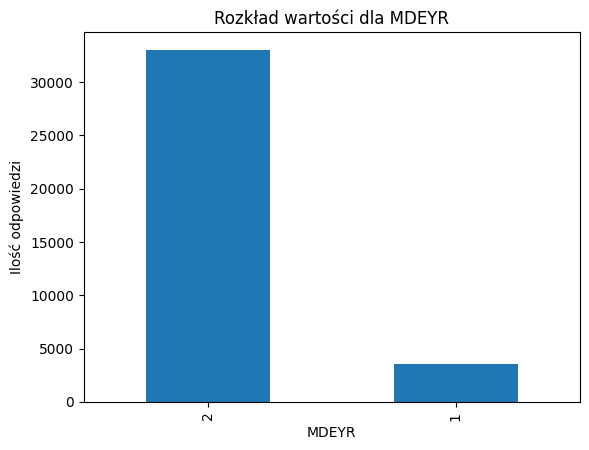

In [7]:
import matplotlib.pyplot as plt
df['MDEYR'].value_counts().plot(kind='bar')
plt.title('Rozkład wartości dla MDEYR')
plt.xlabel('MDEYR')
plt.ylabel('Ilość odpowiedzi')
plt.show()

Na rysunku powyżej widać, że większość respondentów odpowiedziała, że w ostatnim roku nie miała silnego stanu depresyjnego.

Uutworzona zostanie również nowa kolumna `DEPRESSIONTYPELASTYR`, która przyjmie następujące wartości:
    - `0`: brak depresji,
    - `1`: 'czysta' depresja,
    - `2`: depresja somatyczna;
Do jej powstania wykorzystane zostaną kolumny:
    - czy wystąpił silny epizod depresyjny w ostatnim roku `MDEYR`,
    - przy stanach depresyjnych zmmiany apetytu u dorosłych `AD_MDEA3` i młodzieży `YO_MDEA3`,
    - przy stanach depresyjnych problemy ze snem u dorosłych `AD_MDEA4` i młodzieży `YO_MDEA4`,
    - przy stanach depresyjnych poczucie zmęczenia u dorosłych `AD_MDEA6` i młodzieży `YO_MDEA6`.
  
Następnym krokiem jest utworzenie nowej kolumny i dodanie informacji o symptomach.

In [8]:
def depression_type(row):
    if row['MDEYR'] == 1 and row['YO_MDEA3'] == 1 and row['YO_MDEA4'] == 1 and row['YO_MDEA6'] == 1:
        return 2
    elif row['MDEYR'] == 1 and row['AD_MDEA3'] == 1 and row['AD_MDEA4'] == 1 and row['AD_MDEA6'] == 1:
        return 2
    elif row['MDEYR'] == 1:
        return 1
    else:
        return 0
    
df['DEPRESSIONTYPELASTYR'] = df.apply(depression_type, axis=1)

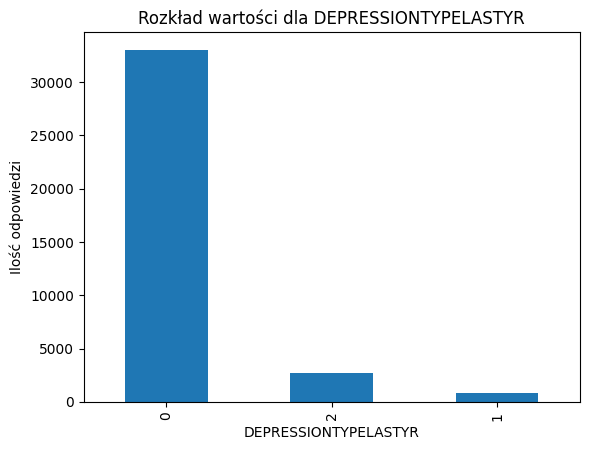

In [9]:
df['DEPRESSIONTYPELASTYR'].value_counts().plot(kind='bar')
plt.title('Rozkład wartości dla DEPRESSIONTYPELASTYR')
plt.xlabel('DEPRESSIONTYPELASTYR')
plt.ylabel('Ilość odpowiedzi')
plt.show()

Jak widać, większość osób, które miały silny epizod depresyjny miały również 3 symptomy somatyczne.

Ostateczna predykcja będzie 2 stopniowa:
- poziom 1: predykcja czy osoba miała silny stan depresyjny w ostatnim roku,
- poziom 2: wykorzystując poziom 1 nastąpi predykcja czy była to depresja 'bezobjawowa' czy somatyczna.

### Wybór i czyszczenie cech

Po przejrzeniu następujących artykułów:
- Silverstein, Brett; Levin, Eitan, "Differences in the developmental
patterns of depression with and without additional somatic symptoms."
Psychiatry Research. Dec 2014, 220, (1-2), 254 - 257. DOI:
10.1016/j.psychres.2014.07.054
- Thompson, Melissa, "Gender, Mental Illness, and Crime." Final Technical
Report. NCJ 224028, Sep 2008. 2007-IJ-CX-0004

oraz przeszukaniu Codebook, do wstępnej analizy wybrane zostały następujące cechy:
- płeć: `IRSEX`,
- wiek: `CATAG7`,
- rasa: `NEWRACE2`,
- współczynnik uzależnienia od narkotyków: `ANYINDEX`,
- kiedy ostatnio brał jakiekolwiek nielegalne narkotyki: `ANYILLICITRC`,
- czy używał marihuany/kokainy w ostatnim roku: `MJCOKELY`
- czy kiedykolwiek użył środków przeciwbólowych do celów niemedycznych: `ANLEVER`,
- czy popełnił przestępstwo: `ANYCRIME`,
- czy kiedykolwiek został aresztowany: `CRIMEHIST`,
- czy pracuje lub chodzi do szkoły: `WORKSCHOOL`,
- poziom edukacji: `IREDUC2`,
- ogólny poziom zdrowia: `HEALTH2`,
- czy respondent ma jakiekolwiek ubezpieczenie zdrowotne: `ANYHLTI2`,
- stan cywilny: `IRMARIT`,
- typ mieszkania: `CACHAR`,
- dochód rodziny: `INCOME`,
- uzależnienie od narkotyków lub alkoholu w ostatnim roku: `DPILLALC`,
- nadużywanie alkoholu w ostatnim roku: `ABUSEALC`,
- gęstość zaludnienia: `REVERSEPOP`.

In [10]:
columns_to_use = [
    'MDEYR',
    'DEPRESSIONTYPELASTYR',
    'IRSEX',
    'CATAG7',
    'NEWRACE2',
    'ANYINDEX',
    'ANYILLICITRC',
    'MJCOKELY',
    'ANLEVER',
    'ANYCRIME',
    'CRIMEHIST',
    'WORKSCHOOL',
    'IREDUC2',
    'HEALTH2',
    'ANYHLTI2',
    'IRMARIT',
    'CACHAR',
    'INCOME',
    'DPILLALC',
    'ABUSEALC',
    'REVERSEPOP'
]

df = df[columns_to_use]
int64_columns = df.select_dtypes(include=['int64']).columns

W niektórych z kolumn wartości wymagają ręcznego poprawienia, ponieważ zostały dobrane w sposób, który mógłby utrudnić analizę.

In [11]:
values_to_replace = {
    'MDEYR': [[2, 0]],
    'IRSEX': [[2, 0]],
    'ANYILLICITRC': [[9, 4]],
    'ANLEVER': [[81, 0], [91, 0]],
    'IRMARIT': [[99, 5]]
}

In [12]:
for column, values in values_to_replace.items():
    for value in values:
        df[column] = df[column].replace(value[0], value[1])

Słownik z oznaczeniami brakujących danych w poszczególnych kolumnach

In [13]:
missing_values = {
    'IRSEX': [],
    'CATAG7': [],
    'NEWRACE2': [],
    'ANYINDEX': [-1],
    'ANYILLICITRC': [],
    'MJCOKELY': [],
    'ANLEVER': [97, 98],
    'ANYCRIME': [-1],
    'CRIMEHIST': [-1],
    'WORKSCHOOL': [-1],
    'IREDUC2': [],
    'HEALTH2': [-9],
    'ANYHLTI2': [94, 97, 98],
    'IRMARIT': [],
    'CACHAR': [-9],
    'INCOME': [],
    'DPILLALC': [],
    'ABUSEALC': [],
    'REVERSEPOP': []    
}

Obliczenie ilości brakujących danych w każdej kolumnie (i procentowego udziału)

In [14]:
indices_with_missing_data = []

for column, missing_values_list in missing_values.items():
    mask = df[column].isin(missing_values_list)
    df.loc[mask, column] = None
    num_of_missing_data = mask.sum()
    print(f'{column}: {num_of_missing_data} ({num_of_missing_data / df.shape[0] * 100:.2f}%)')
    indices_with_missing_data.extend(df[mask].index.to_list())

IRSEX: 0 (0.00%)
CATAG7: 0 (0.00%)
NEWRACE2: 0 (0.00%)
ANYINDEX: 25 (0.07%)
ANYILLICITRC: 0 (0.00%)
MJCOKELY: 0 (0.00%)
ANLEVER: 134 (0.37%)
ANYCRIME: 21 (0.06%)
CRIMEHIST: 74 (0.20%)
WORKSCHOOL: 4 (0.01%)
IREDUC2: 0 (0.00%)
HEALTH2: 10 (0.03%)
ANYHLTI2: 327 (0.90%)
IRMARIT: 0 (0.00%)
CACHAR: 7 (0.02%)
INCOME: 0 (0.00%)
DPILLALC: 0 (0.00%)
ABUSEALC: 0 (0.00%)
REVERSEPOP: 0 (0.00%)


Jeżeli w jakimś rzędzie brakuje przynajmniej 2 wartości to zostanie on usunięty

In [15]:
from collections import Counter
index_counts = Counter(indices_with_missing_data)
indices_to_remove = [index for index, count in index_counts.items() if count >= 2]

print(indices_to_remove)
df = df.drop(indices_to_remove)
df = df.reset_index(drop=True)

[11160, 33603, 18284, 24234, 25274, 32562, 23890, 30175, 34604, 10587]


Sprawdzenie typów wartości w poszczególnych kolumnach

In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36522 entries, 0 to 36521
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MDEYR                 36522 non-null  int64  
 1   DEPRESSIONTYPELASTYR  36522 non-null  int64  
 2   IRSEX                 36522 non-null  float64
 3   CATAG7                36522 non-null  float64
 4   NEWRACE2              36522 non-null  float64
 5   ANYINDEX              36499 non-null  float64
 6   ANYILLICITRC          36522 non-null  float64
 7   MJCOKELY              36522 non-null  float64
 8   ANLEVER               36393 non-null  float64
 9   ANYCRIME              36503 non-null  float64
 10  CRIMEHIST             36453 non-null  float64
 11  WORKSCHOOL            36519 non-null  float64
 12  IREDUC2               36522 non-null  float64
 13  HEALTH2               36512 non-null  float64
 14  ANYHLTI2              36200 non-null  float64
 15  IRMARIT            

In [17]:
print(df['ANYINDEX'].nunique())

12


Ze względu na fakt, że kolumna `ANYINDEX` posiada wartości typu `float64`, gdzie jest 12 unikalnych wartości, to dla ułatwienia wiersze, w których brakuje wartości w tej kolumnie, zostaną usunięte. 

In [18]:
df = df.dropna(subset=['ANYINDEX'])
df = df.reset_index(drop=True)

Pozostałe brakujące wartości zostaną uzupełnione przy pomocy metody KNN.

Uzasadnienie dla poszczególnych kolumns:
- dla `ANYINDEX`, `ANYCRIME`, `CRIMEHIST`, `WORKSCHOOL` wartość `-1` oznacza `Blank` czyli brak wpisanej wartości, a nie ma podanego powodu (nie wynika z tego, że na inne pytanie odpowiedział tak, że tych pytań nie otrzymał, tylko po prostu nie zaznaczył w tych kolumnach nic),
- dla `ANLEVER` wartość `97` oznacza `REFUSED`, które możnaby traktować, że ktoś nie chce podać odpowiedzi, że korzystał kiedyś ze środków przeciwbólowych poza zastosowaniami medycznymi, ze względu na obawę jak go ocenią, ale nie ma pewności, że tak było, a wartość `98` oznacza `BLANK (NO ANSWER)` czyli jest to sytuacja jak dla `ANYINDEX`,
- dla `HEALTH2` wartość `-9` oznacza albo `DON'T KNOW` albo `REFUSED`, więc ponownie nie można wnioskować,
- dla `ANYHLTI2` wartość `94` oznacza `DON'T KNOW`, `97` oznacza `REFUSED`, a `98` oznacza `OTHER MISSING`, więc ponownie brak odpowiedzi nie wynika z odpowiedzi na inne pytanie; duża liczba brakujących odpowiedzi wynika prawdopodobnie z faktu, że w badaniu brała udział młodzież, która może się nie interesować tym czy ma ubezpieczenie,
- dla `CACHAR` wartość `-9` oznacza `BLANK`, a więc ponownie wynika to z nie zaznaczeniem odpowiedzi.

Ze względu na to, że braki nie wynikają z odpowiedzi na inne pytania to uzupełnienie wartości przy pomocy metody k-najbliższych sąsiadów jest uzasadnione. Możnaby też analizować czy odpowiedź `REFUSED` nie ma na celu czegoś ukryć, ale to mogłoby prowadzić do błędnych wniosków.

In [19]:
# Use KNN Imputer to fill missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=11)
df_imputed = imputer.fit_transform(df)

In [20]:
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
df_imputed[int64_columns] = df_imputed[int64_columns].astype('int64')

In [21]:
data_df = df_imputed.copy()

### Analiza czynników wpływających na występowanie depresji

Wyświetlenie przykładowych danych

In [22]:
print(data_df.head())

   MDEYR  DEPRESSIONTYPELASTYR  IRSEX  CATAG7  NEWRACE2  ANYINDEX  \
0      0                     0      1       5         7  0.142857   
1      0                     0      1       4         1  0.142857   
2      0                     0      1       7         1  0.142857   
3      0                     0      1       5         1  0.500000   
4      0                     0      0       7         1  0.142857   

   ANYILLICITRC  MJCOKELY  ANLEVER  ANYCRIME  ...  WORKSCHOOL  IREDUC2  \
0             1         1        0         0  ...           1       11   
1             3         0        0         0  ...           0       10   
2             4         0        0         0  ...           0       10   
3             1         1        1         0  ...           1       10   
4             3         0        0         0  ...           1        8   

   HEALTH2  ANYHLTI2  IRMARIT  CACHAR  INCOME  DPILLALC  ABUSEALC  REVERSEPOP  
0        1         1        4       7       3         0     

Wyświetlenie statystyk poszczególnych kolumn

In [23]:
print(data_df.describe())

              MDEYR  DEPRESSIONTYPELASTYR         IRSEX        CATAG7  \
count  36499.000000          36499.000000  36499.000000  36499.000000   
mean       0.095920              0.170114      0.486013      3.847229   
std        0.294486              0.538118      0.499811      2.077345   
min        0.000000              0.000000      0.000000      1.000000   
25%        0.000000              0.000000      0.000000      2.000000   
50%        0.000000              0.000000      0.000000      4.000000   
75%        0.000000              0.000000      1.000000      6.000000   
max        1.000000              2.000000      1.000000      7.000000   

           NEWRACE2      ANYINDEX  ANYILLICITRC      MJCOKELY       ANLEVER  \
count  36499.000000  36499.000000  36499.000000  36499.000000  36499.000000   
mean       2.280062      0.165461      3.214883      0.173539      0.153812   
std        2.205180      0.096967      1.056589      0.378718      0.360774   
min        1.000000      0

W zbiorze danych widoczne jest, że wiele cech ma małą wartość odchylenia standardowego, co oznacza, że większość respondentów odpowiedziała w jednakowy sposób na dane pytanie.

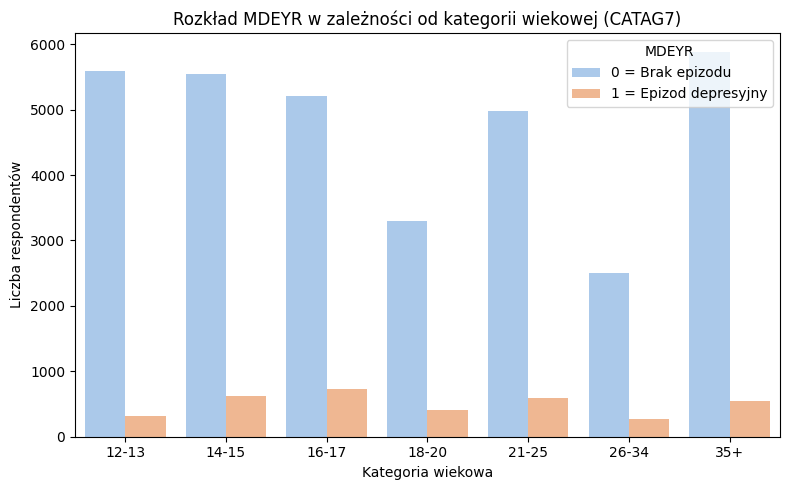

In [24]:
import seaborn as sns

age_labels = {
    1: '12-13',
    2: '14-15',
    3: '16-17',
    4: '18-20',
    5: '21-25',
    6: '26-34',
    7: '35+'
}

data_df['CATAG7_str'] = data_df['CATAG7'].map(age_labels)

plt.figure(figsize=(8, 5))
sns.countplot(
    data=data_df,
    x='CATAG7_str',
    hue='MDEYR',
    palette='pastel',
    order=['12-13', '14-15', '16-17', '18-20', '21-25', '26-34', '35+']
)

plt.title('Rozkład MDEYR w zależności od kategorii wiekowej (CATAG7)')
plt.xlabel('Kategoria wiekowa')
plt.ylabel('Liczba respondentów')
plt.legend(title='MDEYR', labels=['0 = Brak epizodu', '1 = Epizod depresyjny'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Wyniki pokazują, że epizody depresyjne (MDEYR = 1)  najczęsciej w grupie wiekowej 16–17 lat. Jednocześnie większość respondentów w każdej kategorii wiekowej nie doświadczyła epizodów depresyjnych w ostatnim roku.

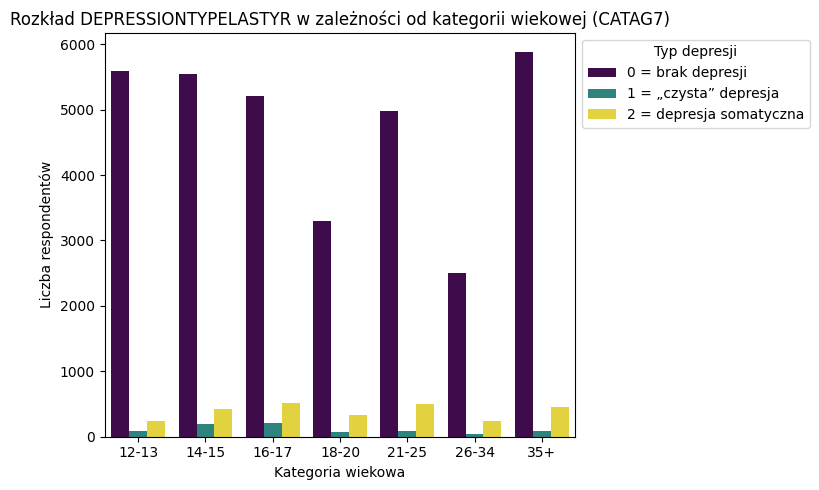

In [25]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=data_df,
    x='CATAG7_str',
    hue='DEPRESSIONTYPELASTYR',
    palette='viridis',
    order=['12-13', '14-15', '16-17', '18-20', '21-25', '26-34', '35+']
)

plt.title('Rozkład DEPRESSIONTYPELASTYR w zależności od kategorii wiekowej (CATAG7)')
plt.xlabel('Kategoria wiekowa')
plt.ylabel('Liczba respondentów')
plt.legend(
    title='Typ depresji',
    labels=[
        '0 = brak depresji',
        '1 = „czysta” depresja',
        '2 = depresja somatyczna'
    ],
    loc='upper left',
    bbox_to_anchor=(1, 1)
)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

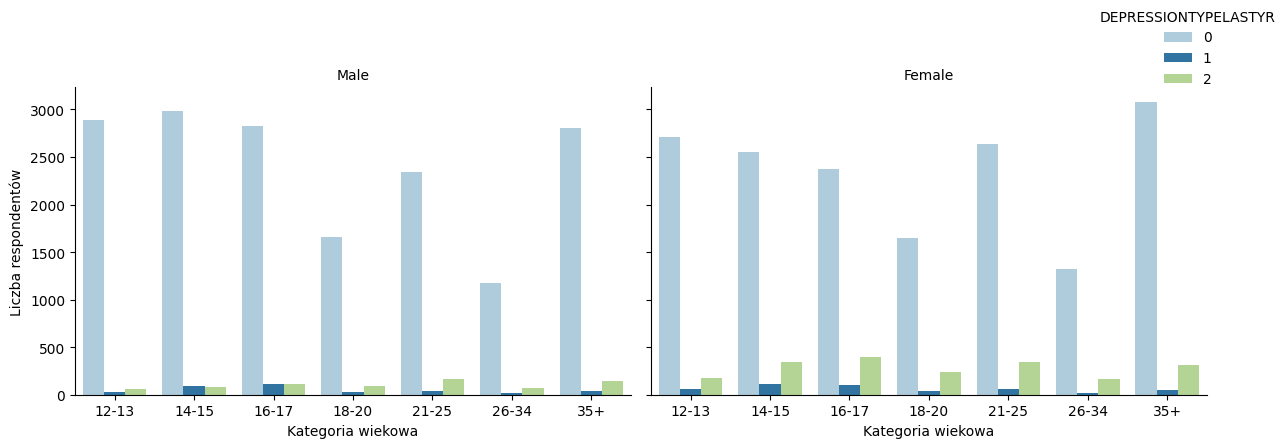

Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i kategorii wiekowej
DEPRESSIONTYPELASTYR     0    1    2  0_percentage  1_percentage  2_percentage
IRSEX_str CATAG7_str                                                          
Female    12-13       2706   59  173     92.103472      2.008169      5.888359
          14-15       2557  109  346     84.893758      3.618858     11.487384
          16-17       2378  101  400     82.598124      3.508163     13.893713
          18-20       1650   42  241     85.359545      2.172788     12.467667
          21-25       2633   57  344     86.783125      1.878708     11.338167
          26-34       1326   21  170     87.409361      1.384311     11.206328
          35+         3079   52  316     89.324050      1.508558      9.167392
Male      12-13       2887   26   61     97.074647      0.874243      2.051110
          14-15       2984   88   83     94.580032      2.789223      2.630745
          16-17       2822  111

In [26]:
sex_labels = {
    1: 'Male',
    0: 'Female'
}
data_df['IRSEX_str'] = data_df['IRSEX'].map(sex_labels)

g = sns.catplot(
    data=data_df,
    x='CATAG7_str',
    hue='DEPRESSIONTYPELASTYR',
    col='IRSEX_str',
    kind='count',
    order=['12-13', '14-15', '16-17', '18-20', '21-25', '26-34', '35+'],
    palette='Paired',
    height=4,
    aspect=1.3,
    legend_out=True
)

g.set_axis_labels("Kategoria wiekowa", "Liczba respondentów")
g.set_titles("{col_name}")
g._legend.set_bbox_to_anchor((1.05, 1))

plt.tight_layout()
plt.show()


table_crosstab = pd.crosstab(
    index=[data_df['IRSEX_str'], data_df['CATAG7_str']],
    columns=data_df['DEPRESSIONTYPELASTYR']
)

table_crosstab_percentage = table_crosstab.div(table_crosstab.sum(axis=1), axis=0) * 100
table_crosstab = table_crosstab.join(table_crosstab_percentage, rsuffix='_percentage')

print("Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i kategorii wiekowej")
print(table_crosstab)

Na podstawie danych widocznych powyżej można wyciągnąć następujące wnioski:
- dla obu płci najmniejszy procent osób z depresją jest w grupie wiekowej `12-13`,
- kategoria `14-15` wśród chłopców jest jedyną, gdzie więcej respondentów miało "czystą depresję" niż depresję somatyczną,
- kobiety mają w każdej grupie wiekowej większy procent respondentów z depresją ogólnie, a także z depresją somatayczną, w przypadku depresji somatycznej jedynie w grupie wiekowej 16-17 mężczyźni mają większy udział procentowy osób z czystą depresją niż kobiety w tej samej kategorii wiekowej

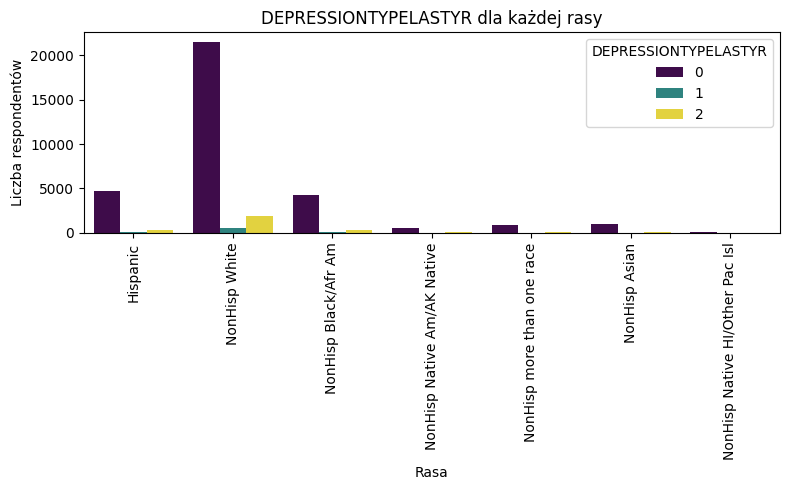

Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i kategorii wiekowej
DEPRESSIONTYPELASTYR                 0    1     2  0_percentage  1_percentage  \
NEWRACE2_str                                                                    
Hispanic                          4669  103   353     91.102439      2.009756   
NonHisp Asian                     1042   21    69     92.049470      1.855124   
NonHisp Black/Afr Am              4230   84   284     91.996520      1.826881   
NonHisp Native Am/AK Native        502   10    41     90.777577      1.808318   
NonHisp Native HI/Other Pac Isl    123    2    13     89.130435      1.449275   
NonHisp White                    21510  535  1843     90.045211      2.239618   
NonHisp more than one race         922   38   105     86.572770      3.568075   

DEPRESSIONTYPELASTYR             2_percentage  
NEWRACE2_str                                   
Hispanic                             6.887805  
NonHisp Asian             

In [27]:
race_labels = {
    1: 'NonHisp White',
    2: 'NonHisp Black/Afr Am',
    3: 'NonHisp Native Am/AK Native',
    4: 'NonHisp Native HI/Other Pac Isl',
    5: 'NonHisp Asian',
    6: 'NonHisp more than one race',
    7: 'Hispanic'
}
data_df['NEWRACE2_str'] = data_df['NEWRACE2'].map(race_labels)

plt.figure(figsize=(8, 5))
sns.countplot(
    data=data_df,
    x='NEWRACE2_str',
    hue='DEPRESSIONTYPELASTYR',
    palette='viridis'
)
plt.title('DEPRESSIONTYPELASTYR dla każdej rasy')
plt.xlabel('Rasa')
plt.ylabel('Liczba respondentów')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


table_crosstab = pd.crosstab(
    index=data_df['NEWRACE2_str'],
    columns=data_df['DEPRESSIONTYPELASTYR']
)

table_crosstab_percentage = table_crosstab.div(table_crosstab.sum(axis=1), axis=0) * 100
table_crosstab = table_crosstab.join(table_crosstab_percentage, rsuffix='_percentage')

print("Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i kategorii wiekowej")
print(table_crosstab)

Różnice pomiędzy rasami w przypadku ogólnego występowania depresji są nieznaczne, jedynie większa różnica występuje dla `NonHisp more than one race`

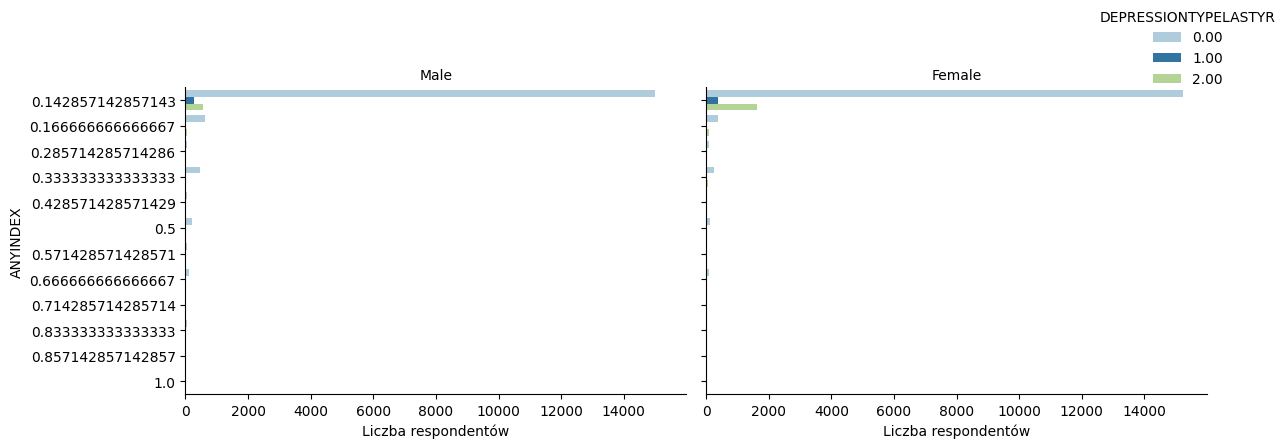

Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i wskaźnika uzależnienia od dowolnego narkotyku
DEPRESSIONTYPELASTYR      0    1     2  0_percentage  1_percentage  \
IRSEX_str ANYINDEX                                                   
Female    0.142857    15235  366  1626     88.436756      2.124572   
          0.166667      385   15    80     80.208333      3.125000   
          0.285714       91    4    32     71.653543      3.149606   
          0.333333      253   15    68     75.297619      4.464286   
          0.428571       38    8    20     57.575758     12.121212   
          0.500000      129   13    37     72.067039      7.262570   
          0.571429       36    3    22     59.016393      4.918033   
          0.666667       77    6    36     64.705882      5.042017   
          0.714286       18    1    19     47.368421      2.631579   
          0.833333       37    3    17     64.912281      5.263158   
          0.857143       16    3 

Text(0.5, 1.0, 'Procentowa liczba osób bez depresji w zależności od wskaźnika uzależnienia od dowolnego narkotyku')

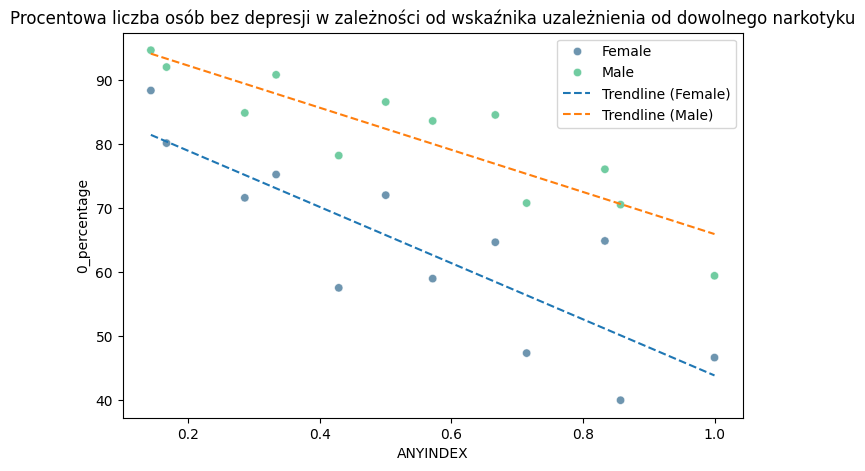

In [28]:
import numpy as np
g = sns.catplot(
    data=data_df,
    y='ANYINDEX',
    hue='DEPRESSIONTYPELASTYR',
    col='IRSEX_str',
    kind='count',
    palette='Paired',
    height=4,
    aspect=1.3,
    legend_out=True
)

for text in g._legend.texts:
    text.set_text(f"{float(text.get_text()):.2f}")
g._legend.set_bbox_to_anchor((1.05, 1))
g._legend.set_title("DEPRESSIONTYPELASTYR")

g.set_axis_labels("Liczba respondentów", "ANYINDEX")
g.set_titles("{col_name}")
g._legend.set_bbox_to_anchor((1.05, 1))

plt.tight_layout()
plt.show()

table_crosstab = pd.crosstab(
    index=[data_df['IRSEX_str'], data_df['ANYINDEX']],
    columns=data_df['DEPRESSIONTYPELASTYR']
)

table_crosstab_percentage = table_crosstab.div(table_crosstab.sum(axis=1), axis=0) * 100
table_crosstab = table_crosstab.join(table_crosstab_percentage, rsuffix='_percentage')

print("Tabela przedstawiająca liczbę osób z danym typem depresji w zależności od płci i wskaźnika uzależnienia od dowolnego narkotyku")
print(table_crosstab)

# Plot 0_percentage on y axis and ANYINDEX on x axis
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=table_crosstab.reset_index(),
    x='ANYINDEX',
    y='0_percentage',
    hue='IRSEX_str',
    palette='viridis',
    alpha=0.7,
)

# Add trendline
for sex in table_crosstab.reset_index()['IRSEX_str'].unique():
    subset = table_crosstab.reset_index()[table_crosstab.reset_index()['IRSEX_str'] == sex]
    z = np.polyfit(subset['ANYINDEX'], subset['0_percentage'], 1)
    p = np.poly1d(z)
    plt.plot(subset['ANYINDEX'], p(subset['ANYINDEX']), linestyle='--', label=f'Trendline ({sex})')

plt.legend()

plt.title('Procentowa liczba osób bez depresji w zależności od wskaźnika uzależnienia od dowolnego narkotyku')

Na podstawie wykersu widoczne jest, że wraz ze wzrostem wskaźnika uzależnienia od narkotyków, trend ilości osób bez depresji spada. Dodatkowo, dla każdej wartości wskaźnika ANYINDEX, wśród kobiet występował większy odsetek respodentół z depresją.

DEPRESSIONTYPELASTYR      0    1     2
ANYCRIME_str                          
Crime                  2880  154   512
No crime              30118  639  2196


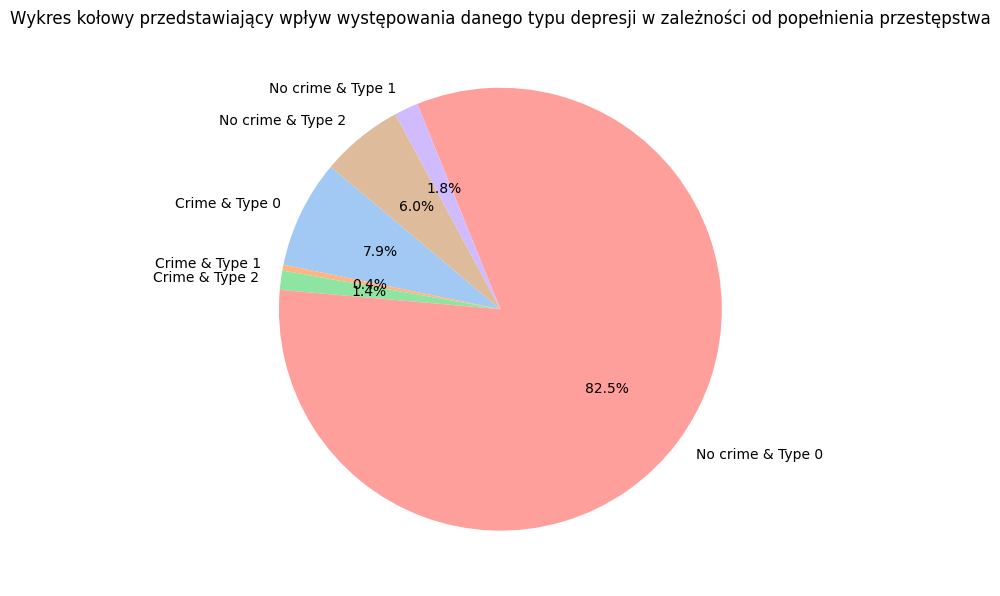

In [29]:
data_df['ANYCRIME'] = data_df['ANYCRIME'].astype(int)


crime_labels = {
    0: 'No crime',
    1: 'Crime'
}
data_df['ANYCRIME_str'] = data_df['ANYCRIME'].map(crime_labels)

table = pd.crosstab(data_df['ANYCRIME_str'], data_df['DEPRESSIONTYPELASTYR'])
print(table)
table_long = table.stack().reset_index()
table_long.columns = ['ANYCRIME_str', 'DEPRESSIONTYPELASTYR', 'Count']

table_long['Label'] = table_long.apply(
    lambda row: f"{row['ANYCRIME_str']} & Type {row['DEPRESSIONTYPELASTYR']}",
    axis=1
)


plt.figure(figsize=(7, 7))

values = table_long['Count']
labels = table_long['Label']

plt.pie(
    x=values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel', n_colors=len(values))
)

plt.title('Wykres kołowy przedstawiający wpływ występowania danego typu depresji w zależności od popełnienia przestępstwa')
plt.tight_layout()
plt.show()


Na podstawie powyższych wyników widać zależność pomiędzy popełnieniem przestępstwa a depresją, ponieważ ok. 19% osób, które popełniły przestępstwo miały depresję, a wśród respondetów, którzy odpowiedzieli, że nigdy nie popełnili przestępstwa odesetek ten wynosi ok 9%.

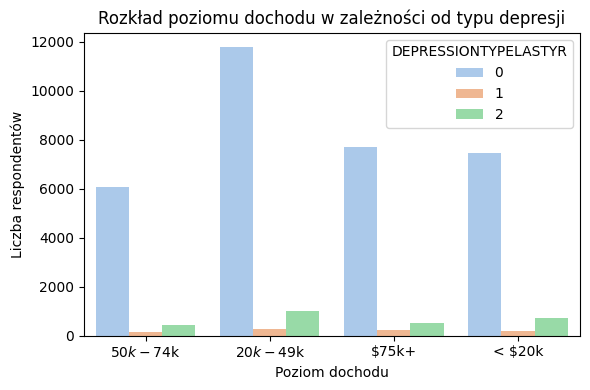

DEPRESSIONTYPELASTYR      0    1     2  0_percentage  1_percentage  \
INCOME_str                                                           
$20k - $49k           11766  259  1017     90.216225      1.985892   
$50k - $74k            6086  138   440     91.326531      2.070828   
$75k+                  7680  217   509     91.363312      2.581489   
< $20k                 7466  179   742     89.018719      2.134255   

DEPRESSIONTYPELASTYR  2_percentage  
INCOME_str                          
$20k - $49k               7.797884  
$50k - $74k               6.602641  
$75k+                     6.055199  
< $20k                    8.847025  


In [30]:
income_labels = {
    1: '< $20k',
    2: '$20k - $49k',
    3: '$50k - $74k',
    4: '$75k+'
}

data_df['INCOME'] = data_df['INCOME'].astype(int)
data_df['INCOME_str'] = data_df['INCOME'].map(income_labels)

plt.figure(figsize=(6,4))
sns.countplot(
    data=data_df,
    x='INCOME_str',
    hue='DEPRESSIONTYPELASTYR',
    palette='pastel'
)
plt.title('Rozkład poziomu dochodu w zależności od typu depresji')
plt.xlabel('Poziom dochodu')
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.show()

table = pd.crosstab(data_df['INCOME_str'], data_df['DEPRESSIONTYPELASTYR'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)

W przypadku dochodu rodziny, ogólny odsetek osób z depresją nieznacznie zmniejsza się, wraz z przejściem na wyższy poziom zarobków. Interesujący jest fakt, że większe zarobki powodują, że odsetek osób z depresją somatyczną jest mniejszy, ale udział "czystej" depresji wśród wszystkich mających depresję się zwiększa.

/tmp/ipykernel_100795/3823392982.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


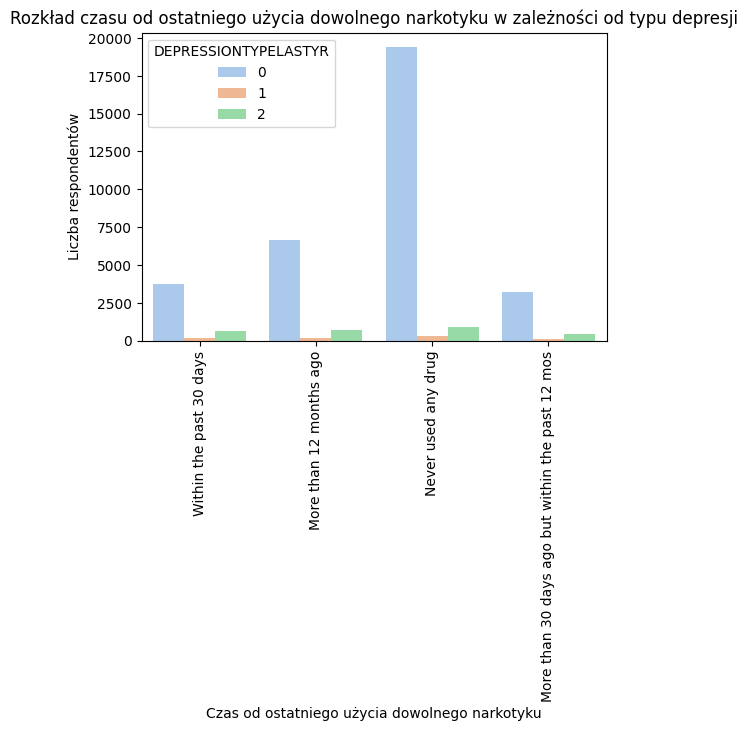

DEPRESSIONTYPELASTYR                                  0    1    2  \
ANYILLICITRC_str                                                    
More than 12 months ago                            6674  170  733   
More than 30 days ago but within the past 12 mos   3211  137  437   
Never used any drug                               19389  322  923   
Within the past 30 days                            3724  164  615   

DEPRESSIONTYPELASTYR                              0_percentage  1_percentage  \
ANYILLICITRC_str                                                               
More than 12 months ago                              88.082354      2.243632   
More than 30 days ago but within the past 12 mos     84.834875      3.619551   
Never used any drug                                  93.966269      1.560531   
Within the past 30 days                              82.700422      3.642016   

DEPRESSIONTYPELASTYR                              2_percentage  
ANYILLICITRC_str                       

In [31]:
recency_any_illicit_labels = {
    1: 'Within the past 30 days',
    2: 'More than 30 days ago but within the past 12 mos',
    3: 'More than 12 months ago',
    4: 'Never used any drug'
}

data_df['ANYILLICITRC'] = data_df['ANYILLICITRC'].astype(int)
data_df['ANYILLICITRC_str'] = data_df['ANYILLICITRC'].map(recency_any_illicit_labels)

plt.figure(figsize=(6,4))
sns.countplot(
    data=data_df,
    x='ANYILLICITRC_str',
    hue='DEPRESSIONTYPELASTYR',
    palette='pastel'
)
plt.title('Rozkład czasu od ostatniego użycia dowolnego narkotyku w zależności od typu depresji')
plt.xlabel('Czas od ostatniego użycia dowolnego narkotyku')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.show()

table = pd.crosstab(data_df['ANYILLICITRC_str'], data_df['DEPRESSIONTYPELASTYR'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)

Na podstawie danych widoczne jest, że im mniej czasu minęło od użycia narkotyków, tym większy jest ogólny procent osób z depresją, z depresją "czystą" i depresją somatyczną.

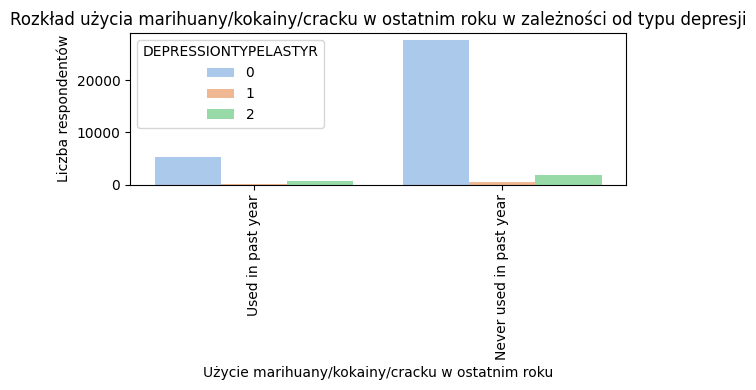

DEPRESSIONTYPELASTYR         0    1     2  0_percentage  1_percentage  \
MJCOKELY_str                                                            
Never used in past year  27655  573  1937     91.679098      1.899552   
Used in past year         5343  220   771     84.354278      3.473319   

DEPRESSIONTYPELASTYR     2_percentage  
MJCOKELY_str                           
Never used in past year      6.421349  
Used in past year           12.172403  


In [32]:
MJCOKELY_labels = {
    0: 'Never used in past year',
    1: 'Used in past year'
}

data_df['MJCOKELY'] = data_df['MJCOKELY'].astype(int)
data_df['MJCOKELY_str'] = data_df['MJCOKELY'].map(MJCOKELY_labels)

plt.figure(figsize=(6,4))
sns.countplot(
    data=data_df,
    x='MJCOKELY_str',
    hue='DEPRESSIONTYPELASTYR',
    palette='pastel'
)
plt.title('Rozkład użycia marihuany/kokainy/cracku w ostatnim roku w zależności od typu depresji')
plt.xlabel('Użycie marihuany/kokainy/cracku w ostatnim roku')
plt.xticks(rotation=90)
plt.ylabel('Liczba respondentów')
plt.tight_layout()
plt.show()

table = pd.crosstab(data_df['MJCOKELY_str'], data_df['DEPRESSIONTYPELASTYR'])
table_percentage = table.div(table.sum(axis=1), axis=0) * 100
table = table.join(table_percentage, rsuffix='_percentage')

print(table)

Podobnie jak w poprzednim porównaniu, użycie narkotyków powoduje, że więcej osób ma depresję jeżeli użyli w ostatnim roku narkotyków.

### Wybór cech do modelu

W poprzedniej części cechy zostały sprawdzone i przeanalizowane, a w tej części obliczona zostanie wartość bezwzględna korelacji każdej cechy z `MDEYR`. Następnie, zaczynając od cechy z największą wartością bezwzględnej korelacji, sprawdzone zostanie, czy wybrana cecha jest istotnie różna, od cech, które zostały wcześniej wybrane. Dodatkowo dla `CACHAR`, `IRMARIT` i `NEWRACE2` zastosowany został one-hot encoding, ponieważ wartości w tych kolumnach nie mogą być sortowane, więc rozbicie wartości na więcej kolumn powinno ułatwić modelowi zrozumienie danych.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(data_df[['CACHAR', 'NEWRACE2', 'IRMARIT']]).toarray()
encoded_columns = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['CACHAR', 'NEWRACE2', 'IRMARIT']))

data_df = pd.concat([data_df, encoded_columns], axis=1)

columns_to_use_after_encoding = columns_to_use + encoded_columns.columns.to_list()
columns_to_use_after_encoding.remove('CACHAR')
columns_to_use_after_encoding.remove('NEWRACE2')
columns_to_use_after_encoding.remove('IRMARIT')
print(columns_to_use_after_encoding)

['MDEYR', 'DEPRESSIONTYPELASTYR', 'IRSEX', 'CATAG7', 'ANYINDEX', 'ANYILLICITRC', 'MJCOKELY', 'ANLEVER', 'ANYCRIME', 'CRIMEHIST', 'WORKSCHOOL', 'IREDUC2', 'HEALTH2', 'ANYHLTI2', 'INCOME', 'DPILLALC', 'ABUSEALC', 'REVERSEPOP', 'CACHAR_1', 'CACHAR_2', 'CACHAR_3', 'CACHAR_4', 'CACHAR_5', 'CACHAR_6', 'CACHAR_7', 'CACHAR_8', 'CACHAR_9', 'NEWRACE2_1', 'NEWRACE2_2', 'NEWRACE2_3', 'NEWRACE2_4', 'NEWRACE2_5', 'NEWRACE2_6', 'NEWRACE2_7', 'IRMARIT_1', 'IRMARIT_2', 'IRMARIT_3', 'IRMARIT_4', 'IRMARIT_5']


<Axes: >

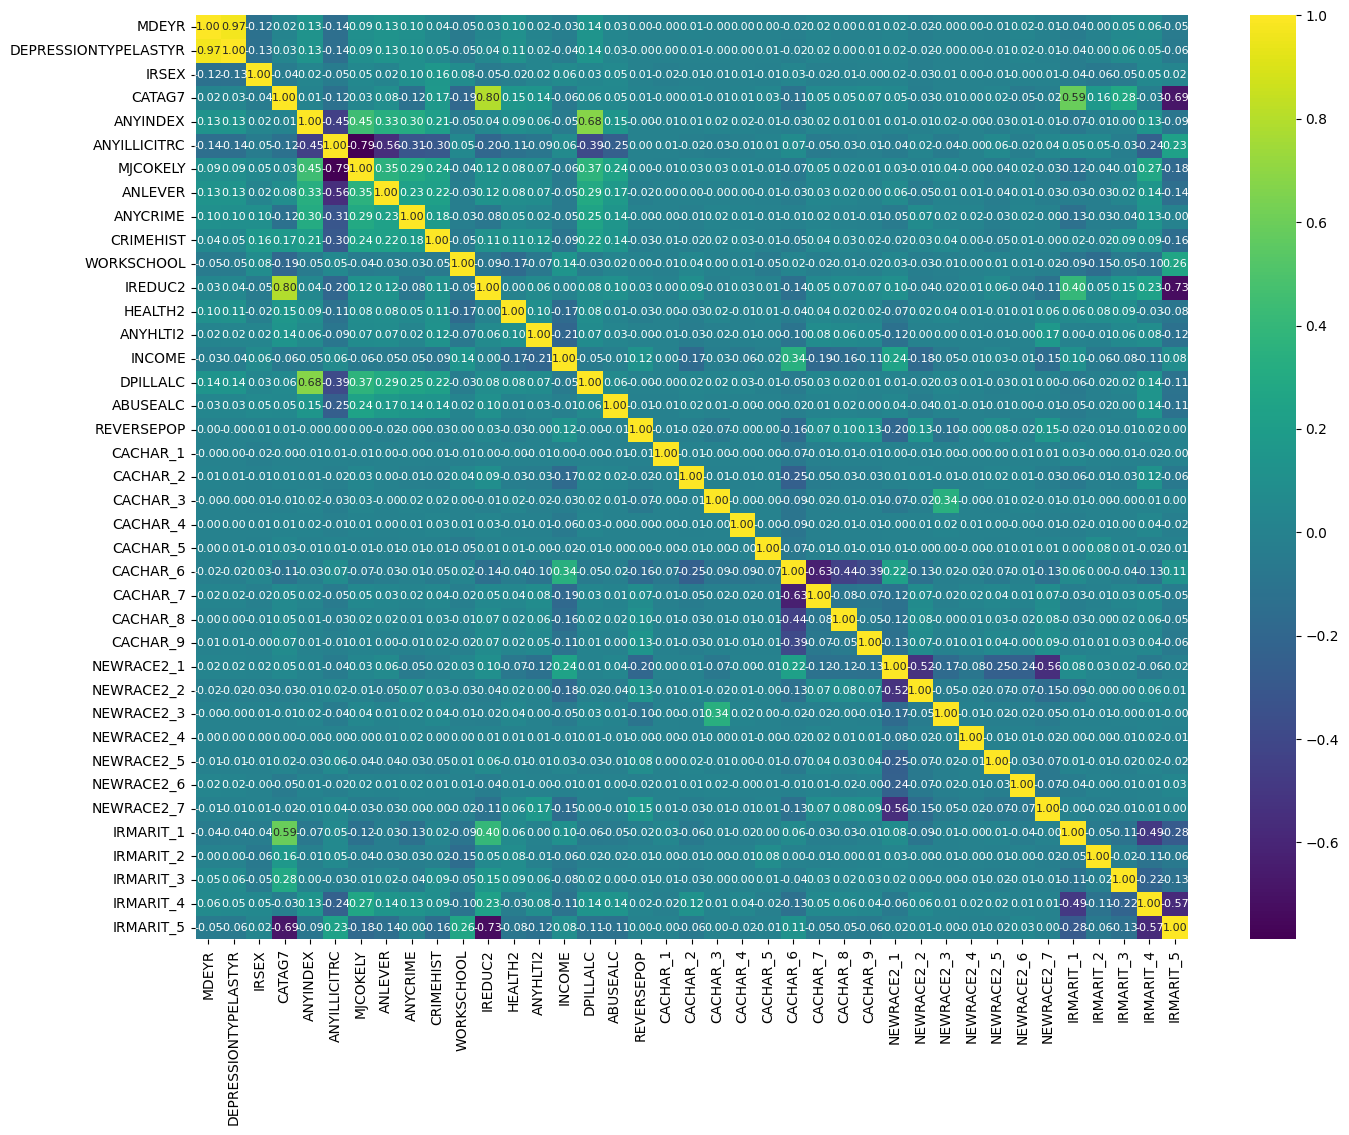

In [ ]:
corr_matrix = data_df[columns_to_use_after_encoding].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(
    data=corr_matrix,
    annot=True,
    cmap='viridis',
    fmt=".2f",
    annot_kws={'size': 8}
)

In [39]:
corr_values = corr_matrix.abs().unstack().sort_values(ascending=False)
corr_values = corr_values['MDEYR'].drop('MDEYR')
corr_values = corr_values.drop('DEPRESSIONTYPELASTYR')
print(corr_values)

ANYILLICITRC    0.144351
DPILLALC        0.140684
ANLEVER         0.132684
ANYINDEX        0.132530
IRSEX           0.117559
HEALTH2         0.104789
ANYCRIME        0.102368
MJCOKELY        0.094199
IRMARIT_4       0.058833
IRMARIT_5       0.054438
IRMARIT_3       0.052384
WORKSCHOOL      0.049756
CRIMEHIST       0.044234
IRMARIT_1       0.042867
IREDUC2         0.034799
ABUSEALC        0.031327
INCOME          0.029193
NEWRACE2_6      0.022578
NEWRACE2_2      0.020480
CACHAR_6        0.019043
ANYHLTI2        0.018803
CATAG7          0.017774
NEWRACE2_1      0.016953
CACHAR_7        0.016029
CACHAR_2        0.010035
NEWRACE2_5      0.009973
NEWRACE2_7      0.009532
CACHAR_9        0.007919
CACHAR_5        0.004406
CACHAR_3        0.002676
NEWRACE2_4      0.002673
REVERSEPOP      0.001787
CACHAR_4        0.001621
NEWRACE2_3      0.001557
IRMARIT_2       0.000902
CACHAR_1        0.000883
CACHAR_8        0.000224
dtype: float64
